### feature selection : time-frequency domain
### Merged M10

In [ ]:
import pandas as pd

# read
df = pd.read_csv('../features/features_with_demo.csv')

# merge M10 activities
df['Activity'] = df['Activity'].str.replace(r'^M10_WT\d+$', 'M10', regex=True)

# save
df.to_csv('../features/features_with_demo_mergedM10.csv', index=False)

print("File Saved")

File Saved


In [ ]:
# Remove subject with poor performance AND activities with less data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import wilcoxon

# read
df = pd.read_csv("../features/features_with_demo_mergedM10.csv")
df.columns = [c.strip() for c in df.columns]


# make sure the groups and labels are string
df["Subject"]  = df["Subject"].astype(str)
df["Activity"] = df["Activity"].astype(str)

# drop cols
meta_all = [
    "window","Subject","subject","Activity","trial_id","sex",
    "most_affected_wrist","most_affected_ankle","dominant_side",
    "age","height_(cm)","weight_(kg)","most_affected_side",
    "hoehn_and_yahr_(stage)","years_since_diagnosis","cit","updrs","Sensor"
]
meta_cols = [c for c in meta_all if c in df.columns]

# feature selection
feature_cols = [c for c in df.columns
                if c not in meta_cols and np.issubdtype(df[c].dtype, np.number)]

# tool
def mean_pm_std(m, s, digits=4):
    return f"{m:.{digits}f} ± {s:.{digits}f}"

def loso_eval(pipeline: Pipeline,
              X: pd.DataFrame, y: pd.Series, groups: pd.Series,
              labels: List[str]) -> Dict:
    """ LOSO at Subject level, return summary, confusion matrix"""    
    logo = LeaveOneGroupOut()
    per_fold = []
    per_class = []
    agg_cm = np.zeros((len(labels), len(labels)), dtype=int)

    for tr_idx, te_idx in logo.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        subj = groups.iloc[te_idx].iloc[0]

        mdl = clone(pipeline)
        mdl.fit(X_tr, y_tr)
        y_hat = mdl.predict(X_te)

        acc  = accuracy_score(y_te, y_hat)
        f1m  = f1_score(y_te, y_hat, average="macro", zero_division=0)
        bacc = balanced_accuracy_score(y_te, y_hat)

        per_fold.append({"Subject": subj, "Accuracy": acc, "MacroF1": f1m, "BalancedAcc": bacc})

    
        rep = classification_report(y_te, y_hat, 
                                labels=sorted(y_te.unique().tolist()),  
                                output_dict=True, 
                                zero_division=0)

        for cls in labels:
            if cls in rep:
                per_class.append({
                    "Subject": subj, "Class": cls,
                    "precision": rep[cls]["precision"],
                    "recall": rep[cls]["recall"],
                    "f1": rep[cls]["f1-score"],
                    "support": rep[cls]["support"]
                })

        agg_cm += confusion_matrix(y_te, y_hat, labels=labels)

    per_fold_df = pd.DataFrame(per_fold).sort_values("Subject")
    per_class_df = pd.DataFrame(per_class)

    summary = {
        "Accuracy_mean": per_fold_df["Accuracy"].mean(),
        "Accuracy_std": per_fold_df["Accuracy"].std(ddof=1),
        "MacroF1_mean": per_fold_df["MacroF1"].mean(),
        "MacroF1_std": per_fold_df["MacroF1"].std(ddof=1),
        "BalancedAcc_mean": per_fold_df["BalancedAcc"].mean(),
        "BalancedAcc_std": per_fold_df["BalancedAcc"].std(ddof=1),
        "n_subjects": per_fold_df["Subject"].nunique()
    }
    return {"summary": summary,
            "per_subject": per_fold_df,
            "per_class": per_class_df,
            "confusion": agg_cm}

def find_poor_subjects(per_subject_df: pd.DataFrame, metric: str = "MacroF1",
                       rule: str = "quantile", q: float = 0.2) -> List[str]:
    s = per_subject_df[metric]
    if rule == "quantile":
        thr = s.quantile(q)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "zscore":
        thr = s.mean() - 2 * s.std(ddof=1)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "iqr":
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        thr = q1 - 1.5 * iqr
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    else:
        raise ValueError("Unknown rule")
    return bad

def class_rarity_table(df: pd.DataFrame, label_col: str = "Activity", subject_col: str = "Subject") -> pd.DataFrame:
    tbl = (df.groupby(label_col)
             .agg(n_windows=(label_col, "size"),
                  n_subjects=(subject_col, "nunique"))
             .reset_index()
             .sort_values(["n_windows", "n_subjects"]))
    total = tbl["n_windows"].sum()
    tbl["percent_windows"] = tbl["n_windows"] / total
    return tbl

# Baseline pipeline
rf = RandomForestClassifier(
    n_estimators=100, max_depth=2, max_features='sqrt',
    min_samples_leaf=1, min_samples_split=2,
    random_state=42, n_jobs=-1,
    class_weight="balanced_subsample"  # None, "balanced_subsample"
)

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),  
    ("fs", SelectKBest(score_func=f_classif, k=70)), 
    ("clf", rf)
])

X_all = df[feature_cols]
y_all = df["Activity"]
g_all = df["Subject"]
labels = sorted(y_all.unique().tolist())

# Baseline LOSO
res_base = loso_eval(pipeline, X_all, y_all, g_all, labels)
print("[BASELINE]",
      "Acc",  mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
      ", MacroF1", mean_pm_std(res_base["summary"]["MacroF1_mean"],  res_base["summary"]["MacroF1_std"]),
      ", BAcc", mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"]),
      ", n_subj", res_base["summary"]["n_subjects"])

# save
res_base["per_subject"].to_csv("loso_per_subject_baseline.csv", index=False)
res_base["per_class"].to_csv("loso_per_class_baseline.csv", index=False)

# ----------- find the subject with poor performance and remove 
bad20 = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="quantile", q=0.2)
badiqr = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="iqr")
print("[POOR SUBJECTS] bottom20%:", bad20)
print("[POOR SUBJECTS] IQR rule :", badiqr)

def eval_remove_subjects(to_remove: List[str]):
    if not to_remove:
        return res_base
    m = ~df["Subject"].isin(to_remove)
    return loso_eval(pipeline, X_all[m], y_all[m], g_all[m], labels=[c for c in labels])

scenarios = {
    "baseline": [],
    "remove_bottom20pct": bad20,
    "remove_IQR": badiqr
}
rows = []
res_cache = {"baseline": res_base}
for name, rm in scenarios.items():
    if name == "baseline":
        res = res_base
    else:
        res = eval_remove_subjects(rm)
    res_cache[name] = res
    rows.append({
        "scenario": name,
        "removed_subjects": ",".join(rm) if rm else "-",
        "n_removed": len(rm),
        "n_subjects_after": res["summary"]["n_subjects"],
        "Acc":   mean_pm_std(res["summary"]["Accuracy_mean"],    res["summary"]["Accuracy_std"]),
        "MacroF1": mean_pm_std(res["summary"]["MacroF1_mean"],   res["summary"]["MacroF1_std"]),
        "BAcc":  mean_pm_std(res["summary"]["BalancedAcc_mean"], res["summary"]["BalancedAcc_std"])
    })
sc_df = pd.DataFrame(rows)
print("\n[SUBJECT-REMOVAL SCENARIOS]\n", sc_df)
sc_df.to_csv("subject_removal_scenarios.csv", index=False)

# Perform a paired Wilcoxon test - MacroF1
def paired_compare(res_A, res_B, metric="MacroF1"):
    A = res_A["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_A"})
    B = res_B["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_B"})
    m = A.merge(B, on="Subject", how="inner")
    if len(m) < 3:
        return len(m), np.nan, np.nan
    stat, p = wilcoxon(m[f"{metric}_A"], m[f"{metric}_B"])
    return len(m), stat, p

if len(bad20) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_bottom20pct"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_bottom20pct: n={n}, p={p:.4g}")
if len(badiqr) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_IQR"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_IQR: n={n}, p={p:.4g}")

# ------------------------ rare activity - stat + Drop vs Merge ------------------
rar = class_rarity_table(df, label_col="Activity", subject_col="Subject")
rar.to_csv("activity_rarity_table.csv", index=False)
print("\n[ACTIVITY RARITY]\n", rar)

# Threshold ：windows<5% OR  < 40%total_subjects
total_subjects = df["Subject"].nunique()
subj_thr = max(3, int(np.ceil(0.4 * total_subjects)))
pct_thr = 0.05
rare_classes = rar.query("(percent_windows < @pct_thr) or (n_subjects < @subj_thr)")["Activity"].tolist()
print(f"[RARE CLASSES] pct<{pct_thr*100:.1f}% or subj<{subj_thr}: {rare_classes}")

def eval_drop_classes(drop_cls: List[str]):
    if not drop_cls:
        return res_base, labels
    m = ~df["Activity"].isin(drop_cls)
    Xk, yk, gk = X_all[m], y_all[m], g_all[m]
    labels_k = sorted(yk.unique().tolist())
    return loso_eval(pipeline, Xk, yk, gk, labels_k), labels_k

def eval_merge_classes(merge_cls: List[str], other_name="ADL_OTHER"):
    if not merge_cls:
        return res_base, labels
    df_m = df.copy()
    df_m.loc[df_m["Activity"].isin(merge_cls), "Activity"] = other_name
    Xm = df_m[feature_cols]; ym = df_m["Activity"]; gm = df_m["Subject"]
    labels_m = sorted(ym.unique().tolist())
    return loso_eval(pipeline, Xm, ym, gm, labels_m), labels_m

res_drop, labels_drop   = eval_drop_classes(rare_classes)
res_merge, labels_merge = eval_merge_classes(rare_classes, other_name="ADL_OTHER")

comp = pd.DataFrame([
    {"scenario": "baseline",
     "n_classes": len(labels),
     "Acc":   mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_base["summary"]["MacroF1_mean"],   res_base["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"])},
    {"scenario": "drop_rare",
     "n_classes": len(labels_drop),
     "Acc":   mean_pm_std(res_drop["summary"]["Accuracy_mean"],    res_drop["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_drop["summary"]["MacroF1_mean"],   res_drop["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_drop["summary"]["BalancedAcc_mean"], res_drop["summary"]["BalancedAcc_std"])},
    {"scenario": "merge_rare_to_OTHER",
     "n_classes": len(labels_merge),
     "Acc":   mean_pm_std(res_merge["summary"]["Accuracy_mean"],   res_merge["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_merge["summary"]["MacroF1_mean"],  res_merge["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_merge["summary"]["BalancedAcc_mean"],res_merge["summary"]["BalancedAcc_std"])}
])
print("\n[RARE-CLASS SCENARIOS]\n", comp)
comp.to_csv("rare_class_scenarios.csv", index=False)

#  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confmat(cm, labels, title="Confusion Matrix", normalize=False):
    if normalize:
        M = cm.astype(float)
        row_sums = M.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        M = M / row_sums
        fmt = ".2f"
    else:
        M = cm.astype(int)    
        fmt = "d"

    plt.figure()
    sns.heatmap(
        M, annot=True, fmt=fmt, cmap="Blues",
        xticklabels=labels, yticklabels=labels,
        linewidths=0.5, linecolor="white", square=True, vmin=0
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confmat(res_base["confusion"], labels, "Baseline (time-frequency)")
plot_confmat(res_drop["confusion"], labels_drop, "Drop Rare (time-frequency)")
plot_confmat(res_merge["confusion"], labels_merge, "Merge Rare to OTHER (time-frequency)")

plot_confmat(res_base["confusion"], labels, "Normalized Baseline (time-frequency)", normalize=True)




---------

----------

### tsfel, HistGradientBoosting

In [ ]:
import pandas as pd

# read
df = pd.read_csv('../features_tsfel/tsfel_features_with_demographics.csv')

# merge M10 activities
df['Activity'] = df['Activity'].str.replace(r'^M10_WT\d+$', 'M10', regex=True)

# save
df.to_csv('../features_tsfel/tsfel_features_with_demographics_mergedM10.csv', index=False)

print("File Saved")

File Saved


In [ ]:
# Remove subject with poor performance AND activities with less data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import wilcoxon

import warnings
warnings.filterwarnings("ignore")


# make sure the groups and labels are string
df["Subject"]  = df["Subject"].astype(str)
df["Activity"] = df["Activity"].astype(str)

# drop
meta_all = [
    "window","Subject","subject","Activity","trial_id","sex",
    "most_affected_wrist","most_affected_ankle","dominant_side",
    "age","height_(cm)","weight_(kg)","most_affected_side",
    "hoehn_and_yahr_(stage)","years_since_diagnosis","cit","updrs","Sensor"
]
meta_cols = [c for c in meta_all if c in df.columns]

# feature selection
feature_cols = [c for c in df.columns
                if c not in meta_cols and np.issubdtype(df[c].dtype, np.number)]

# tool
def mean_pm_std(m, s, digits=4):
    return f"{m:.{digits}f} ± {s:.{digits}f}"

def loso_eval(pipeline: Pipeline,
              X: pd.DataFrame, y: pd.Series, groups: pd.Series,
              labels: List[str]) -> Dict:
    """ LOSO at Subject level, return summary, confusion matrix"""    
    logo = LeaveOneGroupOut()
    per_fold = []
    per_class = []
    agg_cm = np.zeros((len(labels), len(labels)), dtype=int)

    for tr_idx, te_idx in logo.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        subj = groups.iloc[te_idx].iloc[0]

        mdl = clone(pipeline)
        mdl.fit(X_tr, y_tr)
        y_hat = mdl.predict(X_te)

        acc  = accuracy_score(y_te, y_hat)
        f1m  = f1_score(y_te, y_hat, average="macro", zero_division=0)
        bacc = balanced_accuracy_score(y_te, y_hat)

        per_fold.append({"Subject": subj, "Accuracy": acc, "MacroF1": f1m, "BalancedAcc": bacc})

        rep = classification_report(y_te, y_hat, labels=labels, output_dict=True, zero_division=0)
        for cls in labels:
            if cls in rep:
                per_class.append({
                    "Subject": subj, "Class": cls,
                    "precision": rep[cls]["precision"],
                    "recall": rep[cls]["recall"],
                    "f1": rep[cls]["f1-score"],
                    "support": rep[cls]["support"]
                })

        agg_cm += confusion_matrix(y_te, y_hat, labels=labels)

    per_fold_df  = pd.DataFrame(per_fold).sort_values("Subject")
    per_class_df = pd.DataFrame(per_class)

    summary = {
        "Accuracy_mean": per_fold_df["Accuracy"].mean(),
        "Accuracy_std": per_fold_df["Accuracy"].std(ddof=1),
        "MacroF1_mean": per_fold_df["MacroF1"].mean(),
        "MacroF1_std": per_fold_df["MacroF1"].std(ddof=1),
        "BalancedAcc_mean": per_fold_df["BalancedAcc"].mean(),
        "BalancedAcc_std": per_fold_df["BalancedAcc"].std(ddof=1),
        "n_subjects": per_fold_df["Subject"].nunique()
    }
    return {"summary": summary,
            "per_subject": per_fold_df,
            "per_class": per_class_df,
            "confusion": agg_cm}

def find_poor_subjects(per_subject_df: pd.DataFrame, metric: str = "MacroF1",
                       rule: str = "quantile", q: float = 0.2) -> List[str]:
    s = per_subject_df[metric]
    if rule == "quantile":
        thr = s.quantile(q)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "zscore":
        thr = s.mean() - 2 * s.std(ddof=1)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "iqr":
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        thr = q1 - 1.5 * iqr
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    else:
        raise ValueError("Unknown rule")
    return bad

def class_rarity_table(df: pd.DataFrame, label_col: str = "Activity", subject_col: str = "Subject") -> pd.DataFrame:
    tbl = (df.groupby(label_col)
             .agg(n_windows=(label_col, "size"),
                  n_subjects=(subject_col, "nunique"))
             .reset_index()
             .sort_values(["n_windows", "n_subjects"]))
    total = tbl["n_windows"].sum()
    tbl["percent_windows"] = tbl["n_windows"] / total
    return tbl

# Baseline
rf = HistGradientBoostingClassifier(
    max_iter=200,
    max_depth=2, 
    learning_rate=0.01, 
    l2_regularization=70.0, 
    random_state=42,
    early_stopping=False    
)


pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("fs", SelectKBest(score_func=f_classif, k=70)),  
    ("clf", rf)
])

X_all = df[feature_cols]
y_all = df["Activity"]
g_all = df["Subject"]
labels = sorted(y_all.unique().tolist())

# Baseline LOSO
res_base = loso_eval(pipeline, X_all, y_all, g_all, labels)
print("[BASELINE]",
      "Acc",  mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
      "| MacroF1", mean_pm_std(res_base["summary"]["MacroF1_mean"],  res_base["summary"]["MacroF1_std"]),
      "| BAcc", mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"]),
      "| n_subj", res_base["summary"]["n_subjects"])

# save
res_base["per_subject"].to_csv("loso_per_subject_baseline.csv", index=False)
res_base["per_class"].to_csv("loso_per_class_baseline.csv", index=False)

# ------------ find the subject with poor performance and remove -------------
bad20 = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="quantile", q=0.2)
badiqr = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="iqr")
print("[POOR SUBJECTS] bottom20%:", bad20)
print("[POOR SUBJECTS] IQR rule :", badiqr)

def eval_remove_subjects(to_remove: List[str]):
    if not to_remove:
        return res_base
    m = ~df["Subject"].isin(to_remove)
    return loso_eval(pipeline, X_all[m], y_all[m], g_all[m], labels=[c for c in labels])

scenarios = {
    "baseline": [],
    "remove_bottom20pct": bad20,
    "remove_IQR": badiqr
}
rows = []
res_cache = {"baseline": res_base}
for name, rm in scenarios.items():
    if name == "baseline":
        res = res_base
    else:
        res = eval_remove_subjects(rm)
    res_cache[name] = res
    rows.append({
        "scenario": name,
        "removed_subjects": ",".join(rm) if rm else "-",
        "n_removed": len(rm),
        "n_subjects_after": res["summary"]["n_subjects"],
        "Acc":   mean_pm_std(res["summary"]["Accuracy_mean"],    res["summary"]["Accuracy_std"]),
        "MacroF1": mean_pm_std(res["summary"]["MacroF1_mean"],   res["summary"]["MacroF1_std"]),
        "BAcc":  mean_pm_std(res["summary"]["BalancedAcc_mean"], res["summary"]["BalancedAcc_std"])
    })
sc_df = pd.DataFrame(rows)
print("\n[SUBJECT-REMOVAL SCENARIOS]\n", sc_df)
sc_df.to_csv("subject_removal_scenarios.csv", index=False)

# Perform a paired Wilcoxon test - MacroF1
def paired_compare(res_A, res_B, metric="MacroF1"):
    A = res_A["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_A"})
    B = res_B["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_B"})
    m = A.merge(B, on="Subject", how="inner")
    if len(m) < 3:
        return len(m), np.nan, np.nan
    stat, p = wilcoxon(m[f"{metric}_A"], m[f"{metric}_B"])
    return len(m), stat, p

if len(bad20) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_bottom20pct"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_bottom20pct: n={n}, p={p:.4g}")
if len(badiqr) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_IQR"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_IQR: n={n}, p={p:.4g}")

# ------------------------ rare activity - stat + Drop vs Merge ------------------
rar = class_rarity_table(df, label_col="Activity", subject_col="Subject")
rar.to_csv("activity_rarity_table.csv", index=False)
print("\n[ACTIVITY RARITY]\n", rar)

# Threshold ：windows<5% OR  < 40%total_subjects
total_subjects = df["Subject"].nunique()
subj_thr = max(3, int(np.ceil(0.4 * total_subjects)))
pct_thr = 0.05
rare_classes = rar.query("(percent_windows < @pct_thr) or (n_subjects < @subj_thr)")["Activity"].tolist()
print(f"[RARE CLASSES] pct<{pct_thr*100:.1f}% or subj<{subj_thr}: {rare_classes}")

def eval_drop_classes(drop_cls: List[str]):
    if not drop_cls:
        return res_base, labels
    m = ~df["Activity"].isin(drop_cls)
    Xk, yk, gk = X_all[m], y_all[m], g_all[m]
    labels_k = sorted(yk.unique().tolist())
    return loso_eval(pipeline, Xk, yk, gk, labels_k), labels_k

def eval_merge_classes(merge_cls: List[str], other_name="ADL_OTHER"):
    if not merge_cls:
        return res_base, labels
    df_m = df.copy()
    df_m.loc[df_m["Activity"].isin(merge_cls), "Activity"] = other_name
    Xm = df_m[feature_cols]; ym = df_m["Activity"]; gm = df_m["Subject"]
    labels_m = sorted(ym.unique().tolist())
    return loso_eval(pipeline, Xm, ym, gm, labels_m), labels_m

res_drop, labels_drop   = eval_drop_classes(rare_classes)
res_merge, labels_merge = eval_merge_classes(rare_classes, other_name="ADL_OTHER")

comp = pd.DataFrame([
    {"scenario": "baseline",
     "n_classes": len(labels),
     "Acc":   mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_base["summary"]["MacroF1_mean"],   res_base["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"])},
    {"scenario": "drop_rare",
     "n_classes": len(labels_drop),
     "Acc":   mean_pm_std(res_drop["summary"]["Accuracy_mean"],    res_drop["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_drop["summary"]["MacroF1_mean"],   res_drop["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_drop["summary"]["BalancedAcc_mean"], res_drop["summary"]["BalancedAcc_std"])},
    {"scenario": "merge_rare_to_OTHER",
     "n_classes": len(labels_merge),
     "Acc":   mean_pm_std(res_merge["summary"]["Accuracy_mean"],   res_merge["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_merge["summary"]["MacroF1_mean"],  res_merge["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_merge["summary"]["BalancedAcc_mean"],res_merge["summary"]["BalancedAcc_std"])}
])
print("\n[RARE-CLASS SCENARIOS]\n", comp)
comp.to_csv("rare_class_scenarios.csv", index=False)

###
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confmat(cm, labels, title="Confusion Matrix", normalize=False):
    if normalize:
        M = cm.astype(float)
        row_sums = M.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        M = M / row_sums
        fmt = ".2f"
    else:
        M = cm.astype(int)    
        fmt = "d"

    plt.figure()
    sns.heatmap(
        M, annot=True, fmt=fmt, cmap="Blues",
        xticklabels=labels, yticklabels=labels,
        linewidths=0.5, linecolor="white", square=True, vmin=0
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confmat(res_base["confusion"], labels, "Baseline (tsfel)")
plot_confmat(res_drop["confusion"], labels_drop, "Drop Rare (tsfel)")
plot_confmat(res_merge["confusion"], labels_merge, "Merge Rare to OTHER (tsfel)")

plot_confmat(res_base["confusion"], labels, "Normalized Baseline (tsfel)", normalize=True)


---------

--------

### tsfel + 4, class_weighted, RF+PCA

In [ ]:
import pandas as pd

df = pd.read_csv('../features_tsfel_4/tsfel_features_windowed_additional_with_demographics.csv')

# merge M10 activities
df['Activity'] = df['Activity'].str.replace(r'^M10_WT\d+$', 'M10', regex=True)

# save
df.to_csv('../features_tsfel_4/tsfel_features_windowed_additional_with_demographics_mergedM10.csv', index=False)

print("File Saved")

File Saved


In [ ]:
# Remove subject with poor performance AND activities with less data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import wilcoxon

# read
df = pd.read_csv("../features_tsfel_4/tsfel_features_windowed_additional_with_demographics_mergedM10.csv")
df.columns = [c.strip() for c in df.columns]


# make sure the groups and labels are string
df["Subject"]  = df["Subject"].astype(str)
df["Activity"] = df["Activity"].astype(str)

# drop
meta_all = [
    "window","Subject","subject","Activity","trial_id","sex",
    "most_affected_wrist","most_affected_ankle","dominant_side",
    "age","height_(cm)","weight_(kg)","most_affected_side",
    "hoehn_and_yahr_(stage)","years_since_diagnosis","cit","updrs","Sensor"
]
meta_cols = [c for c in meta_all if c in df.columns]

# feature selection
feature_cols = [c for c in df.columns
                if c not in meta_cols and np.issubdtype(df[c].dtype, np.number)]
print(f"[INFO] {len(feature_cols)} feature cols have been selected. eg.:", feature_cols[:10])

# tool
def mean_pm_std(m, s, digits=4):
    return f"{m:.{digits}f} ± {s:.{digits}f}"

def loso_eval(pipeline: Pipeline,
              X: pd.DataFrame, y: pd.Series, groups: pd.Series,
              labels: List[str]) -> Dict:
    """ do LOSO at Subject level, return summary, confusion matrix"""    
    logo = LeaveOneGroupOut()
    per_fold = []
    per_class = []
    agg_cm = np.zeros((len(labels), len(labels)), dtype=int)

    for tr_idx, te_idx in logo.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        subj = groups.iloc[te_idx].iloc[0]

        mdl = clone(pipeline)
        mdl.fit(X_tr, y_tr)
        y_hat = mdl.predict(X_te)

        acc  = accuracy_score(y_te, y_hat)
        f1m  = f1_score(y_te, y_hat, average="macro", zero_division=0)
        bacc = balanced_accuracy_score(y_te, y_hat)

        per_fold.append({"Subject": subj, "Accuracy": acc, "MacroF1": f1m, "BalancedAcc": bacc})

        # 
        rep = classification_report(y_te, y_hat, 
                                labels=sorted(y_te.unique().tolist()), 
                                output_dict=True, 
                                zero_division=0)

        for cls in labels:
            if cls in rep:
                per_class.append({
                    "Subject": subj, "Class": cls,
                    "precision": rep[cls]["precision"],
                    "recall": rep[cls]["recall"],
                    "f1": rep[cls]["f1-score"],
                    "support": rep[cls]["support"]
                })

        agg_cm += confusion_matrix(y_te, y_hat, labels=labels)

    per_fold_df  = pd.DataFrame(per_fold).sort_values("Subject")
    per_class_df = pd.DataFrame(per_class)

    summary = {
        "Accuracy_mean": per_fold_df["Accuracy"].mean(),
        "Accuracy_std": per_fold_df["Accuracy"].std(ddof=1),
        "MacroF1_mean": per_fold_df["MacroF1"].mean(),
        "MacroF1_std": per_fold_df["MacroF1"].std(ddof=1),
        "BalancedAcc_mean": per_fold_df["BalancedAcc"].mean(),
        "BalancedAcc_std": per_fold_df["BalancedAcc"].std(ddof=1),
        "n_subjects": per_fold_df["Subject"].nunique()
    }
    return {"summary": summary,
            "per_subject": per_fold_df,
            "per_class": per_class_df,
            "confusion": agg_cm}

def find_poor_subjects(per_subject_df: pd.DataFrame, metric: str = "MacroF1",
                       rule: str = "quantile", q: float = 0.2) -> List[str]:
    s = per_subject_df[metric]
    if rule == "quantile":
        thr = s.quantile(q)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "zscore":
        thr = s.mean() - 2 * s.std(ddof=1)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "iqr":
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        thr = q1 - 1.5 * iqr
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    else:
        raise ValueError("Unknown rule")
    return bad

def class_rarity_table(df: pd.DataFrame, label_col: str = "Activity", subject_col: str = "Subject") -> pd.DataFrame:
    tbl = (df.groupby(label_col)
             .agg(n_windows=(label_col, "size"),
                  n_subjects=(subject_col, "nunique"))
             .reset_index()
             .sort_values(["n_windows", "n_subjects"]))
    total = tbl["n_windows"].sum()
    tbl["percent_windows"] = tbl["n_windows"] / total
    return tbl

# Baseline 
rf = RandomForestClassifier(
    n_estimators=200, max_depth=3, max_features='sqrt',
    min_samples_leaf=2, min_samples_split=2,
    random_state=42, n_jobs=-1,
    class_weight="balanced_subsample" 
)


pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),  
    ("pca", PCA(n_components=50)),
    ("clf", rf)
])

X_all = df[feature_cols]
y_all = df["Activity"]
g_all = df["Subject"]
labels = sorted(y_all.unique().tolist())

# BAseline LOSO
res_base = loso_eval(pipeline, X_all, y_all, g_all, labels)
print("[BASELINE]",
      "Acc",  mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
      "| MacroF1", mean_pm_std(res_base["summary"]["MacroF1_mean"],  res_base["summary"]["MacroF1_std"]),
      "| BAcc", mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"]),
      "| n_subj", res_base["summary"]["n_subjects"])

# save
res_base["per_subject"].to_csv("loso_per_subject_baseline.csv", index=False)
res_base["per_class"].to_csv("loso_per_class_baseline.csv", index=False)

# ----- find the subject with poor performance and remove -------------
bad20 = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="quantile", q=0.2)
badiqr = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="iqr")
print("[POOR SUBJECTS] bottom20%:", bad20)
print("[POOR SUBJECTS] IQR rule :", badiqr)

def eval_remove_subjects(to_remove: List[str]):
    if not to_remove:
        return res_base
    m = ~df["Subject"].isin(to_remove)
    return loso_eval(pipeline, X_all[m], y_all[m], g_all[m], labels=[c for c in labels])

scenarios = {
    "baseline": [],
    "remove_bottom20pct": bad20,
    "remove_IQR": badiqr
}
rows = []
res_cache = {"baseline": res_base}
for name, rm in scenarios.items():
    if name == "baseline":
        res = res_base
    else:
        res = eval_remove_subjects(rm)
    res_cache[name] = res
    rows.append({
        "scenario": name,
        "removed_subjects": ",".join(rm) if rm else "-",
        "n_removed": len(rm),
        "n_subjects_after": res["summary"]["n_subjects"],
        "Acc":   mean_pm_std(res["summary"]["Accuracy_mean"],    res["summary"]["Accuracy_std"]),
        "MacroF1": mean_pm_std(res["summary"]["MacroF1_mean"],   res["summary"]["MacroF1_std"]),
        "BAcc":  mean_pm_std(res["summary"]["BalancedAcc_mean"], res["summary"]["BalancedAcc_std"])
    })
sc_df = pd.DataFrame(rows)
print("\n[SUBJECT-REMOVAL SCENARIOS]\n", sc_df)
sc_df.to_csv("subject_removal_scenarios.csv", index=False)

# Perform a paired Wilcoxon test - MacroF1
def paired_compare(res_A, res_B, metric="MacroF1"):
    A = res_A["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_A"})
    B = res_B["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_B"})
    m = A.merge(B, on="Subject", how="inner")
    if len(m) < 3:
        return len(m), np.nan, np.nan
    stat, p = wilcoxon(m[f"{metric}_A"], m[f"{metric}_B"])
    return len(m), stat, p

if len(bad20) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_bottom20pct"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_bottom20pct: n={n}, p={p:.4g}")
if len(badiqr) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_IQR"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_IQR: n={n}, p={p:.4g}")

# ------------------------ rare activity - stat + Drop vs Merge ------------------
rar = class_rarity_table(df, label_col="Activity", subject_col="Subject")
rar.to_csv("activity_rarity_table.csv", index=False)
print("\n[ACTIVITY RARITY]\n", rar)

# Threshold ：windows<5% OR  < 40%total_subjects
total_subjects = df["Subject"].nunique()
subj_thr = max(3, int(np.ceil(0.4 * total_subjects)))
pct_thr = 0.05
rare_classes = rar.query("(percent_windows < @pct_thr) or (n_subjects < @subj_thr)")["Activity"].tolist()
print(f"[RARE CLASSES] pct<{pct_thr*100:.1f}% or subj<{subj_thr}: {rare_classes}")

def eval_drop_classes(drop_cls: List[str]):
    if not drop_cls:
        return res_base, labels
    m = ~df["Activity"].isin(drop_cls)
    Xk, yk, gk = X_all[m], y_all[m], g_all[m]
    labels_k = sorted(yk.unique().tolist())
    return loso_eval(pipeline, Xk, yk, gk, labels_k), labels_k

def eval_merge_classes(merge_cls: List[str], other_name="ADL_OTHER"):
    if not merge_cls:
        return res_base, labels
    df_m = df.copy()
    df_m.loc[df_m["Activity"].isin(merge_cls), "Activity"] = other_name
    Xm = df_m[feature_cols]; ym = df_m["Activity"]; gm = df_m["Subject"]
    labels_m = sorted(ym.unique().tolist())
    return loso_eval(pipeline, Xm, ym, gm, labels_m), labels_m

res_drop, labels_drop   = eval_drop_classes(rare_classes)
res_merge, labels_merge = eval_merge_classes(rare_classes, other_name="ADL_OTHER")

comp = pd.DataFrame([
    {"scenario": "baseline",
     "n_classes": len(labels),
     "Acc":   mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_base["summary"]["MacroF1_mean"],   res_base["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"])},
    {"scenario": "drop_rare",
     "n_classes": len(labels_drop),
     "Acc":   mean_pm_std(res_drop["summary"]["Accuracy_mean"],    res_drop["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_drop["summary"]["MacroF1_mean"],   res_drop["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_drop["summary"]["BalancedAcc_mean"], res_drop["summary"]["BalancedAcc_std"])},
    {"scenario": "merge_rare_to_OTHER",
     "n_classes": len(labels_merge),
     "Acc":   mean_pm_std(res_merge["summary"]["Accuracy_mean"],   res_merge["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_merge["summary"]["MacroF1_mean"],  res_merge["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_merge["summary"]["BalancedAcc_mean"],res_merge["summary"]["BalancedAcc_std"])}
])
print("\n[RARE-CLASS SCENARIOS]\n", comp)
comp.to_csv("rare_class_scenarios.csv", index=False)

# 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confmat(cm, labels, title="Confusion Matrix", normalize=False):
    if normalize:
        M = cm.astype(float)
        row_sums = M.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        M = M / row_sums
        fmt = ".2f"
    else:
        M = cm.astype(int)    
        fmt = "d"

    plt.figure()
    sns.heatmap(
        M, annot=True, fmt=fmt, cmap="Blues",
        xticklabels=labels, yticklabels=labels,
        linewidths=0.5, linecolor="white", square=True, vmin=0
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confmat(res_base["confusion"], labels, "Baseline (tsfel+4+cw)")
plot_confmat(res_drop["confusion"], labels_drop, "Drop Rare (tsfel+4+cw)")
plot_confmat(res_merge["confusion"], labels_merge, "Merge Rare to OTHER (tsfel+4+cw)")

plot_confmat(res_base["confusion"], labels, "Normalized Baseline (tsfel+4+cw)", normalize=True)


----

----

### tsfel + 4, NO class_weighted, Random Forest

In [ ]:
# # Remove subject with poor performance AND activities with less data
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# from typing import List, Dict, Tuple
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.decomposition import PCA
# from sklearn.metrics import (
#     accuracy_score, f1_score, balanced_accuracy_score,
#     classification_report, confusion_matrix
# )
# from sklearn.base import clone
# from sklearn.ensemble import RandomForestClassifier
# from scipy.stats import wilcoxon

# # read

# df = pd.read_csv("../features_tsfel_4/tsfel_features_windowed_additional_with_demographics_mergedM10.csv")
# df.columns = [c.strip() for c in df.columns]


# df["Subject"]  = df["Subject"].astype(str)
# df["Activity"] = df["Activity"].astype(str)

# meta_all = [
#     "window","Subject","subject","Activity","trial_id","sex",
#     "most_affected_wrist","most_affected_ankle","dominant_side",
#     "age","height_(cm)","weight_(kg)","most_affected_side",
#     "hoehn_and_yahr_(stage)","years_since_diagnosis","cit","updrs","Sensor"
# ]
# meta_cols = [c for c in meta_all if c in df.columns]

# feature_cols = [c for c in df.columns
#                 if c not in meta_cols and np.issubdtype(df[c].dtype, np.number)]

# # tool
# def mean_pm_std(m, s, digits=4):
#     return f"{m:.{digits}f} ± {s:.{digits}f}"

# def loso_eval(pipeline: Pipeline,
#               X: pd.DataFrame, y: pd.Series, groups: pd.Series,
#               labels: List[str]) -> Dict:
#     """ do LOSO at Subject level, return summary, confusion matrix"""    
#     logo = LeaveOneGroupOut()
#     per_fold = []
#     per_class = []
#     agg_cm = np.zeros((len(labels), len(labels)), dtype=int)

#     for tr_idx, te_idx in logo.split(X, y, groups):
#         X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
#         y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
#         subj = groups.iloc[te_idx].iloc[0]

#         mdl = clone(pipeline)
#         mdl.fit(X_tr, y_tr)
#         y_hat = mdl.predict(X_te)

#         acc  = accuracy_score(y_te, y_hat)
#         f1m  = f1_score(y_te, y_hat, average="macro", zero_division=0)
#         bacc = balanced_accuracy_score(y_te, y_hat)

#         per_fold.append({"Subject": subj, "Accuracy": acc, "MacroF1": f1m, "BalancedAcc": bacc})

#         # 
#         rep = classification_report(y_te, y_hat, 
#                                 labels=sorted(y_te.unique().tolist()), 
#                                 output_dict=True, 
#                                 zero_division=0)
#         # rep = classification_report(y_te, y_hat, labels=labels, output_dict=True, zero_division=0)
#         for cls in labels:
#             if cls in rep:
#                 per_class.append({
#                     "Subject": subj, "Class": cls,
#                     "precision": rep[cls]["precision"],
#                     "recall": rep[cls]["recall"],
#                     "f1": rep[cls]["f1-score"],
#                     "support": rep[cls]["support"]
#                 })

#         agg_cm += confusion_matrix(y_te, y_hat, labels=labels)

#     per_fold_df  = pd.DataFrame(per_fold).sort_values("Subject")
#     per_class_df = pd.DataFrame(per_class)

#     summary = {
#         "Accuracy_mean": per_fold_df["Accuracy"].mean(),
#         "Accuracy_std": per_fold_df["Accuracy"].std(ddof=1),
#         "MacroF1_mean": per_fold_df["MacroF1"].mean(),
#         "MacroF1_std": per_fold_df["MacroF1"].std(ddof=1),
#         "BalancedAcc_mean": per_fold_df["BalancedAcc"].mean(),
#         "BalancedAcc_std":   per_fold_df["BalancedAcc"].std(ddof=1),
#         "n_subjects": per_fold_df["Subject"].nunique()
#     }
#     return {"summary": summary,
#             "per_subject": per_fold_df,
#             "per_class": per_class_df,
#             "confusion": agg_cm}

# def find_poor_subjects(per_subject_df: pd.DataFrame, metric: str = "MacroF1",
#                        rule: str = "quantile", q: float = 0.2) -> List[str]:
#     s = per_subject_df[metric]
#     if rule == "quantile":
#         thr = s.quantile(q)
#         bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
#     elif rule == "zscore":
#         thr = s.mean() - 2 * s.std(ddof=1)
#         bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
#     elif rule == "iqr":
#         q1, q3 = s.quantile(0.25), s.quantile(0.75)
#         iqr = q3 - q1
#         thr = q1 - 1.5 * iqr
#         bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
#     else:
#         raise ValueError("Unknown rule")
#     return bad

# def class_rarity_table(df: pd.DataFrame, label_col: str = "Activity", subject_col: str = "Subject") -> pd.DataFrame:
#     tbl = (df.groupby(label_col)
#              .agg(n_windows=(label_col, "size"),
#                   n_subjects=(subject_col, "nunique"))
#              .reset_index()
#              .sort_values(["n_windows", "n_subjects"]))
#     total = tbl["n_windows"].sum()
#     tbl["percent_windows"] = tbl["n_windows"] / total
#     return tbl

# # Baseline 
# rf = RandomForestClassifier(
#     n_estimators=250, max_depth=3, max_features='log2',
#     min_samples_leaf=4, min_samples_split=2,
#     random_state=42, n_jobs=-1,
#     class_weight=None 
# )


# pipeline = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler(with_mean=True, with_std=True)), 
#     ("fs", SelectKBest(score_func=f_classif, k=200)),
#     # ("pca", PCA(n_components=50)),
#     ("clf", rf)
# ])

# X_all = df[feature_cols]
# y_all = df["Activity"]
# g_all = df["Subject"]
# labels = sorted(y_all.unique().tolist())

# # Baseline  LOSO
# res_base = loso_eval(pipeline, X_all, y_all, g_all, labels)
# print("[BASELINE]",
#       "Acc",  mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
#       "| MacroF1", mean_pm_std(res_base["summary"]["MacroF1_mean"],  res_base["summary"]["MacroF1_std"]),
#       "| BAcc", mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"]),
#       "| n_subj", res_base["summary"]["n_subjects"])

# # save
# res_base["per_subject"].to_csv("loso_per_subject_baseline.csv", index=False)
# res_base["per_class"].to_csv("loso_per_class_baseline.csv", index=False)

# # -- find the subject with poor performance and remove 
# bad20 = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="quantile", q=0.2)
# badiqr = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="iqr")
# print("[POOR SUBJECTS] bottom20%:", bad20)
# print("[POOR SUBJECTS] IQR rule :", badiqr)

# def eval_remove_subjects(to_remove: List[str]):
#     if not to_remove:
#         return res_base
#     m = ~df["Subject"].isin(to_remove)
#     return loso_eval(pipeline, X_all[m], y_all[m], g_all[m], labels=[c for c in labels])

# scenarios = {
#     "baseline": [],
#     "remove_bottom20pct": bad20,
#     "remove_IQR": badiqr
# }
# rows = []
# res_cache = {"baseline": res_base}
# for name, rm in scenarios.items():
#     if name == "baseline":
#         res = res_base
#     else:
#         res = eval_remove_subjects(rm)
#     res_cache[name] = res
#     rows.append({
#         "scenario": name,
#         "removed_subjects": ",".join(rm) if rm else "-",
#         "n_removed": len(rm),
#         "n_subjects_after": res["summary"]["n_subjects"],
#         "Acc":   mean_pm_std(res["summary"]["Accuracy_mean"],    res["summary"]["Accuracy_std"]),
#         "MacroF1": mean_pm_std(res["summary"]["MacroF1_mean"],   res["summary"]["MacroF1_std"]),
#         "BAcc":  mean_pm_std(res["summary"]["BalancedAcc_mean"], res["summary"]["BalancedAcc_std"])
#     })
# sc_df = pd.DataFrame(rows)
# print("\n[SUBJECT-REMOVAL SCENARIOS]\n", sc_df)
# sc_df.to_csv("subject_removal_scenarios.csv", index=False)

# # Perform a paired Wilcoxon test - MacroF1
# def paired_compare(res_A, res_B, metric="MacroF1"):
#     A = res_A["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_A"})
#     B = res_B["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_B"})
#     m = A.merge(B, on="Subject", how="inner")
#     if len(m) < 3:
#         return len(m), np.nan, np.nan
#     stat, p = wilcoxon(m[f"{metric}_A"], m[f"{metric}_B"])
#     return len(m), stat, p

# if len(bad20) > 0:
#     n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_bottom20pct"], metric="MacroF1")
#     print(f"[Wilcoxon] baseline vs remove_bottom20pct: n={n}, p={p:.4g}")
# if len(badiqr) > 0:
#     n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_IQR"], metric="MacroF1")
#     print(f"[Wilcoxon] baseline vs remove_IQR: n={n}, p={p:.4g}")

# # ------------------------ rare activity - stat + Drop vs Merge ------------------
# rar = class_rarity_table(df, label_col="Activity", subject_col="Subject")
# rar.to_csv("activity_rarity_table.csv", index=False)
# print("\n[ACTIVITY RARITY]\n", rar)

# # Threshold ：windows<5% OR  < 40%total_subjects
# total_subjects = df["Subject"].nunique()
# subj_thr = max(3, int(np.ceil(0.4 * total_subjects)))
# pct_thr = 0.05
# rare_classes = rar.query("(percent_windows < @pct_thr) or (n_subjects < @subj_thr)")["Activity"].tolist()
# print(f"[RARE CLASSES] pct<{pct_thr*100:.1f}% or subj<{subj_thr}: {rare_classes}")

# def eval_drop_classes(drop_cls: List[str]):
#     if not drop_cls:
#         return res_base, labels
#     m = ~df["Activity"].isin(drop_cls)
#     Xk, yk, gk = X_all[m], y_all[m], g_all[m]
#     labels_k = sorted(yk.unique().tolist())
#     return loso_eval(pipeline, Xk, yk, gk, labels_k), labels_k

# def eval_merge_classes(merge_cls: List[str], other_name="ADL_OTHER"):
#     if not merge_cls:
#         return res_base, labels
#     df_m = df.copy()
#     df_m.loc[df_m["Activity"].isin(merge_cls), "Activity"] = other_name
#     Xm = df_m[feature_cols]; ym = df_m["Activity"]; gm = df_m["Subject"]
#     labels_m = sorted(ym.unique().tolist())
#     return loso_eval(pipeline, Xm, ym, gm, labels_m), labels_m

# res_drop, labels_drop   = eval_drop_classes(rare_classes)
# res_merge, labels_merge = eval_merge_classes(rare_classes, other_name="ADL_OTHER")

# comp = pd.DataFrame([
#     {"scenario": "baseline",
#      "n_classes": len(labels),
#      "Acc":   mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
#      "MacroF1": mean_pm_std(res_base["summary"]["MacroF1_mean"],   res_base["summary"]["MacroF1_std"]),
#      "BAcc":  mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"])},
#     {"scenario": "drop_rare",
#      "n_classes": len(labels_drop),
#      "Acc":   mean_pm_std(res_drop["summary"]["Accuracy_mean"],    res_drop["summary"]["Accuracy_std"]),
#      "MacroF1": mean_pm_std(res_drop["summary"]["MacroF1_mean"],   res_drop["summary"]["MacroF1_std"]),
#      "BAcc":  mean_pm_std(res_drop["summary"]["BalancedAcc_mean"], res_drop["summary"]["BalancedAcc_std"])},
#     {"scenario": "merge_rare_to_OTHER",
#      "n_classes": len(labels_merge),
#      "Acc":   mean_pm_std(res_merge["summary"]["Accuracy_mean"],   res_merge["summary"]["Accuracy_std"]),
#      "MacroF1": mean_pm_std(res_merge["summary"]["MacroF1_mean"],  res_merge["summary"]["MacroF1_std"]),
#      "BAcc":  mean_pm_std(res_merge["summary"]["BalancedAcc_mean"],res_merge["summary"]["BalancedAcc_std"])}
# ])
# print("\n[RARE-CLASS SCENARIOS]\n", comp)
# comp.to_csv("rare_class_scenarios.csv", index=False)

# # 
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# def plot_confmat(cm, labels, title="Confusion Matrix", normalize=False):
#     if normalize:
#         M = cm.astype(float)
#         row_sums = M.sum(axis=1, keepdims=True)
#         row_sums[row_sums == 0] = 1.0
#         M = M / row_sums
#         fmt = ".2f"
#     else:
#         M = cm.astype(int)     
#         fmt = "d"

#     plt.figure()
#     sns.heatmap(
#         M, annot=True, fmt=fmt, cmap="Blues",
#         xticklabels=labels, yticklabels=labels,
#         linewidths=0.5, linecolor="white", square=True, vmin=0
#     )
#     plt.title(title)
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.xticks(rotation=45, ha="right")
#     plt.yticks(rotation=0)
#     plt.tight_layout()
#     plt.show()

# plot_confmat(res_base["confusion"], labels, "Baseline (tsfel+4+NOcw)")
# plot_confmat(res_drop["confusion"], labels_drop, "Drop Rare (tsfel+4+NOcw)")
# plot_confmat(res_merge["confusion"], labels_merge, "Merge Rare to OTHER  (tsfel+4+NOcw)")

# plot_confmat(res_base["confusion"], labels, "Normalized Baseline (tsfel+4+NOcw)", normalize=True)


---------

----------

### tsfel + 4 (bagging, RandomForest, PCA)

[INFO] 3841 feature cols have been selected. eg.: ['ankle_Acc_X_0_Absolute energy', 'ankle_Acc_X_0_Area under the curve', 'ankle_Acc_X_0_Autocorrelation', 'ankle_Acc_X_0_Average power', 'ankle_Acc_X_0_Centroid', 'ankle_Acc_X_0_ECDF Percentile Count_0', 'ankle_Acc_X_0_ECDF Percentile Count_1', 'ankle_Acc_X_0_ECDF Percentile_0', 'ankle_Acc_X_0_ECDF Percentile_1', 'ankle_Acc_X_0_ECDF_0']


d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_

[BASELINE] Acc 0.5269 ± 0.1178 | MacroF1 0.4501 ± 0.1157 | BAcc 0.5171 ± 0.1089 | n_subj 21
[POOR SUBJECTS] bottom20%: ['11', '21', '24', '29', '4']
[POOR SUBJECTS] IQR rule : []


d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



[SUBJECT-REMOVAL SCENARIOS]
              scenario removed_subjects  n_removed  n_subjects_after  \
0            baseline                -          0                21   
1  remove_bottom20pct    11,21,24,29,4          5                16   
2          remove_IQR                -          0                21   

               Acc          MacroF1             BAcc  
0  0.5269 ± 0.1178  0.4501 ± 0.1157  0.5171 ± 0.1089  
1  0.5868 ± 0.1178  0.4969 ± 0.1157  0.5678 ± 0.1089  
2  0.5269 ± 0.1178  0.4501 ± 0.1157  0.5171 ± 0.1089  
[Wilcoxon] baseline vs remove_bottom20pct: n=16, p=0.5619

[ACTIVITY RARITY]
   Activity  n_windows  n_subjects  percent_windows
1      M11        430          13         0.064632
5       M8        600          19         0.090185
2       M5        625          21         0.093943
3       M6        761          21         0.114384
6       M9        838          21         0.125958
4       M7       1032          21         0.155118
0      M10       2367         

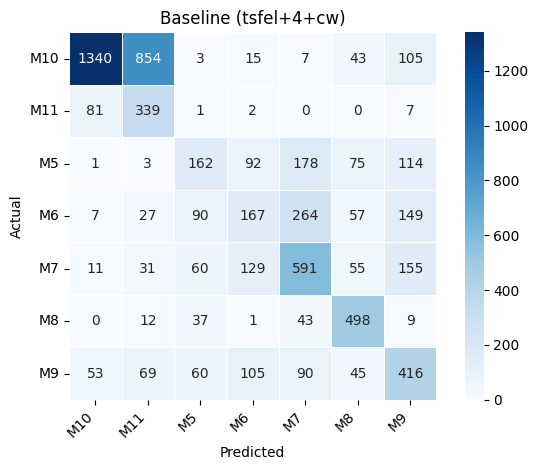

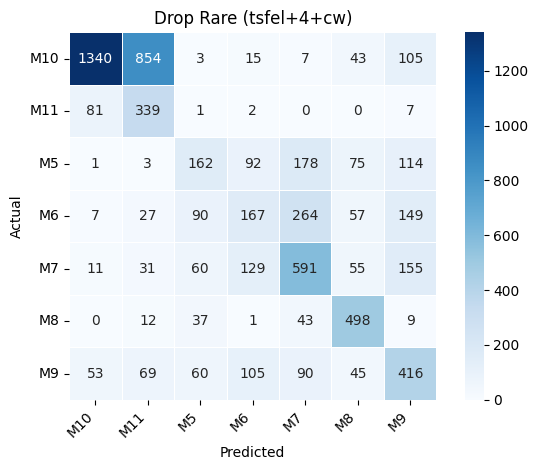

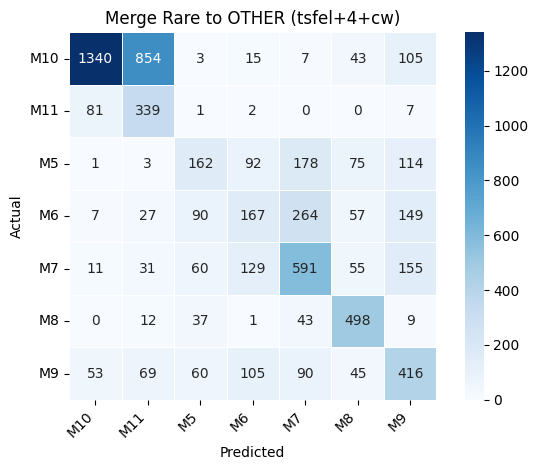

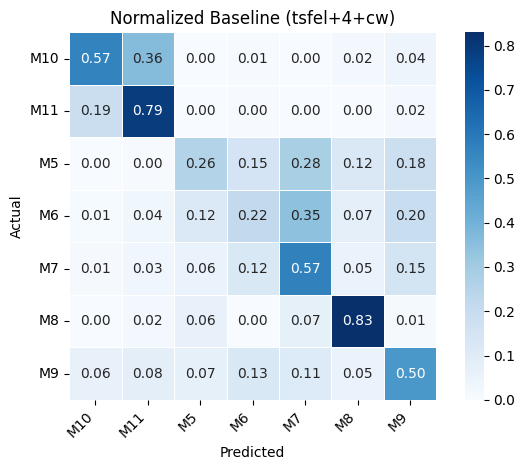

In [ ]:
# Remove subject with poor performance AND activities with less data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from scipy.stats import wilcoxon

# read
df = pd.read_csv("../features_tsfel_4/tsfel_features_windowed_additional_with_demographics_mergedM10.csv")
df.columns = [c.strip() for c in df.columns]

# make sure the groups and labels are string
df["Subject"]  = df["Subject"].astype(str)
df["Activity"] = df["Activity"].astype(str)

# drop
meta_all = [
    "window","Subject","subject","Activity","trial_id","sex",
    "most_affected_wrist","most_affected_ankle","dominant_side",
    "age","height_(cm)","weight_(kg)","most_affected_side",
    "hoehn_and_yahr_(stage)","years_since_diagnosis","cit","updrs","Sensor"
]
meta_cols = [c for c in meta_all if c in df.columns]

# feature selection
feature_cols = [c for c in df.columns
                if c not in meta_cols and np.issubdtype(df[c].dtype, np.number)]
print(f"[INFO] {len(feature_cols)} feature cols have been selected. eg.:", feature_cols[:10])

# tool
def mean_pm_std(m, s, digits=4):
    return f"{m:.{digits}f} ± {s:.{digits}f}"

def loso_eval(pipeline: Pipeline,
              X: pd.DataFrame, y: pd.Series, groups: pd.Series,
              labels: List[str]) -> Dict:
    """ do LOSO at Subject level, return summary, confusion matrix"""    
    logo = LeaveOneGroupOut()
    per_fold = []
    per_class = []
    agg_cm = np.zeros((len(labels), len(labels)), dtype=int)

    for tr_idx, te_idx in logo.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        subj = groups.iloc[te_idx].iloc[0]

        mdl = clone(pipeline)
        mdl.fit(X_tr, y_tr)
        y_hat = mdl.predict(X_te)

        acc  = accuracy_score(y_te, y_hat)
        f1m  = f1_score(y_te, y_hat, average="macro", zero_division=0)
        bacc = balanced_accuracy_score(y_te, y_hat)

        per_fold.append({"Subject": subj, "Accuracy": acc, "MacroF1": f1m, "BalancedAcc": bacc})

        # 
        rep = classification_report(y_te, y_hat, 
                                labels=sorted(y_te.unique().tolist()), 
                                output_dict=True, 
                                zero_division=0)

        for cls in labels:
            if cls in rep:
                per_class.append({
                    "Subject": subj, "Class": cls,
                    "precision": rep[cls]["precision"],
                    "recall": rep[cls]["recall"],
                    "f1": rep[cls]["f1-score"],
                    "support": rep[cls]["support"]
                })

        agg_cm += confusion_matrix(y_te, y_hat, labels=labels)

    per_fold_df  = pd.DataFrame(per_fold).sort_values("Subject")
    per_class_df = pd.DataFrame(per_class)

    summary = {
        "Accuracy_mean": per_fold_df["Accuracy"].mean(),
        "Accuracy_std": per_fold_df["Accuracy"].std(ddof=1),
        "MacroF1_mean": per_fold_df["MacroF1"].mean(),
        "MacroF1_std": per_fold_df["MacroF1"].std(ddof=1),
        "BalancedAcc_mean": per_fold_df["BalancedAcc"].mean(),
        "BalancedAcc_std": per_fold_df["BalancedAcc"].std(ddof=1),
        "n_subjects": per_fold_df["Subject"].nunique()
    }
    return {"summary": summary,
            "per_subject": per_fold_df,
            "per_class": per_class_df,
            "confusion": agg_cm}

def find_poor_subjects(per_subject_df: pd.DataFrame, metric: str = "MacroF1",
                       rule: str = "quantile", q: float = 0.2) -> List[str]:
    s = per_subject_df[metric]
    if rule == "quantile":
        thr = s.quantile(q)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "zscore":
        thr = s.mean() - 2 * s.std(ddof=1)
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    elif rule == "iqr":
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        thr = q1 - 1.5 * iqr
        bad = per_subject_df.loc[s <= thr, "Subject"].tolist()
    else:
        raise ValueError("Unknown rule")
    return bad

def class_rarity_table(df: pd.DataFrame, label_col: str = "Activity", subject_col: str = "Subject") -> pd.DataFrame:
    tbl = (df.groupby(label_col)
             .agg(n_windows=(label_col, "size"),
                  n_subjects=(subject_col, "nunique"))
             .reset_index()
             .sort_values(["n_windows", "n_subjects"]))
    total = tbl["n_windows"].sum()
    tbl["percent_windows"] = tbl["n_windows"] / total
    return tbl

# Baseline - Bagging with RandomForest
base_estimator = RandomForestClassifier(
    n_estimators=200, 
    max_depth=3, 
    max_features='sqrt',
    min_samples_leaf=2, 
    min_samples_split=2,
    random_state=42, 
    n_jobs=1,  
    class_weight="balanced"  
)

# 
bagging_clf = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=10,  
    random_state=42,
    n_jobs=-1  
)

# Pipeline
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(n_components=0.6)), 
    ("bagging", bagging_clf) 
])

X_all = df[feature_cols]
y_all = df["Activity"]
g_all = df["Subject"]
labels = sorted(y_all.unique().tolist())

# BAseline LOSO
res_base = loso_eval(pipeline, X_all, y_all, g_all, labels)
print("[BASELINE]",
      "Acc",  mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
      "| MacroF1", mean_pm_std(res_base["summary"]["MacroF1_mean"],  res_base["summary"]["MacroF1_std"]),
      "| BAcc", mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"]),
      "| n_subj", res_base["summary"]["n_subjects"])

# save
res_base["per_subject"].to_csv("loso_per_subject_baseline.csv", index=False)
res_base["per_class"].to_csv("loso_per_class_baseline.csv", index=False)

# -- find the subject with poor performance and remove -------
bad20 = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="quantile", q=0.2)
badiqr = find_poor_subjects(res_base["per_subject"], metric="MacroF1", rule="iqr")
print("[POOR SUBJECTS] bottom20%:", bad20)
print("[POOR SUBJECTS] IQR rule :", badiqr)

def eval_remove_subjects(to_remove: List[str]):
    if not to_remove:
        return res_base
    m = ~df["Subject"].isin(to_remove)
    return loso_eval(pipeline, X_all[m], y_all[m], g_all[m], labels=[c for c in labels])

scenarios = {
    "baseline": [],
    "remove_bottom20pct": bad20,
    "remove_IQR": badiqr
}
rows = []
res_cache = {"baseline": res_base}
for name, rm in scenarios.items():
    if name == "baseline":
        res = res_base
    else:
        res = eval_remove_subjects(rm)
    res_cache[name] = res
    rows.append({
        "scenario": name,
        "removed_subjects": ",".join(rm) if rm else "-",
        "n_removed": len(rm),
        "n_subjects_after": res["summary"]["n_subjects"],
        "Acc":   mean_pm_std(res["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
        "MacroF1": mean_pm_std(res["summary"]["MacroF1_mean"],   res_base["summary"]["MacroF1_std"]),
        "BAcc":  mean_pm_std(res["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"])
    })
sc_df = pd.DataFrame(rows)
print("\n[SUBJECT-REMOVAL SCENARIOS]\n", sc_df)
sc_df.to_csv("subject_removal_scenarios.csv", index=False)

# Perform a paired Wilcoxon test - MacroF1
def paired_compare(res_A, res_B, metric="MacroF1"):
    A = res_A["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_A"})
    B = res_B["per_subject"][["Subject", metric]].rename(columns={metric: f"{metric}_B"})
    m = A.merge(B, on="Subject", how="inner")
    if len(m) < 3:
        return len(m), np.nan, np.nan
    stat, p = wilcoxon(m[f"{metric}_A"], m[f"{metric}_B"])
    return len(m), stat, p

if len(bad20) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_bottom20pct"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_bottom20pct: n={n}, p={p:.4g}")
if len(badiqr) > 0:
    n, stat, p = paired_compare(res_cache["baseline"], res_cache["remove_IQR"], metric="MacroF1")
    print(f"[Wilcoxon] baseline vs remove_IQR: n={n}, p={p:.4g}")

# ------------------------ rare activity - stat + Drop vs Merge ------------------
rar = class_rarity_table(df, label_col="Activity", subject_col="Subject")
rar.to_csv("activity_rarity_table.csv", index=False)
print("\n[ACTIVITY RARITY]\n", rar)

# Threshold ：windows<5% OR  < 40%total_subjects
total_subjects = df["Subject"].nunique()
subj_thr = max(3, int(np.ceil(0.4 * total_subjects)))
pct_thr = 0.05
rare_classes = rar.query("(percent_windows < @pct_thr) or (n_subjects < @subj_thr)")["Activity"].tolist()
print(f"[RARE CLASSES] pct<{pct_thr*100:.1f}% or subj<{subj_thr}: {rare_classes}")

def eval_drop_classes(drop_cls: List[str]):
    if not drop_cls:
        return res_base, labels
    m = ~df["Activity"].isin(drop_cls)
    Xk, yk, gk = X_all[m], y_all[m], g_all[m]
    labels_k = sorted(yk.unique().tolist())
    return loso_eval(pipeline, Xk, yk, gk, labels_k), labels_k

def eval_merge_classes(merge_cls: List[str], other_name="ADL_OTHER"):
    if not merge_cls:
        return res_base, labels
    df_m = df.copy()
    df_m.loc[df_m["Activity"].isin(merge_cls), "Activity"] = other_name
    Xm = df_m[feature_cols]; ym = df_m["Activity"]; gm = df_m["Subject"]
    labels_m = sorted(ym.unique().tolist())
    return loso_eval(pipeline, Xm, ym, gm, labels_m), labels_m

res_drop, labels_drop   = eval_drop_classes(rare_classes)
res_merge, labels_merge = eval_merge_classes(rare_classes, other_name="ADL_OTHER")

comp = pd.DataFrame([
    {"scenario": "baseline",
     "n_classes": len(labels),
     "Acc":   mean_pm_std(res_base["summary"]["Accuracy_mean"],    res_base["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_base["summary"]["MacroF1_mean"],   res_base["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_base["summary"]["BalancedAcc_mean"], res_base["summary"]["BalancedAcc_std"])},
    {"scenario": "drop_rare",
     "n_classes": len(labels_drop),
     "Acc":   mean_pm_std(res_drop["summary"]["Accuracy_mean"],    res_drop["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_drop["summary"]["MacroF1_mean"],   res_drop["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_drop["summary"]["BalancedAcc_mean"], res_drop["summary"]["BalancedAcc_std"])},
    {"scenario": "merge_rare_to_OTHER",
     "n_classes": len(labels_merge),
     "Acc":   mean_pm_std(res_merge["summary"]["Accuracy_mean"],   res_merge["summary"]["Accuracy_std"]),
     "MacroF1": mean_pm_std(res_merge["summary"]["MacroF1_mean"],  res_merge["summary"]["MacroF1_std"]),
     "BAcc":  mean_pm_std(res_merge["summary"]["BalancedAcc_mean"],res_merge["summary"]["BalancedAcc_std"])}
])
print("\n[RARE-CLASS SCENARIOS]\n", comp)
comp.to_csv("rare_class_scenarios.csv", index=False)

# 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confmat(cm, labels, title="Confusion Matrix", normalize=False):
    if normalize:
        M = cm.astype(float)
        row_sums = M.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        M = M / row_sums
        fmt = ".2f"
    else:
        M = cm.astype(int)    
        fmt = "d"

    plt.figure()
    sns.heatmap(
        M, annot=True, fmt=fmt, cmap="Blues",
        xticklabels=labels, yticklabels=labels,
        linewidths=0.5, linecolor="white", square=True, vmin=0
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confmat(res_base["confusion"], labels, "Baseline (tsfel+4+cw)")
plot_confmat(res_drop["confusion"], labels_drop, "Drop Rare (tsfel+4+cw)")
plot_confmat(res_merge["confusion"], labels_merge, "Merge Rare to OTHER (tsfel+4+cw)")

plot_confmat(res_base["confusion"], labels, "Normalized Baseline (tsfel+4+cw)", normalize=True)